['data/000.jpg', 'data/001.jpg', 'data/002.jpg', 'data/003.jpg', 'data/004.jpg', 'data/005.jpg', 'data/006.jpg']


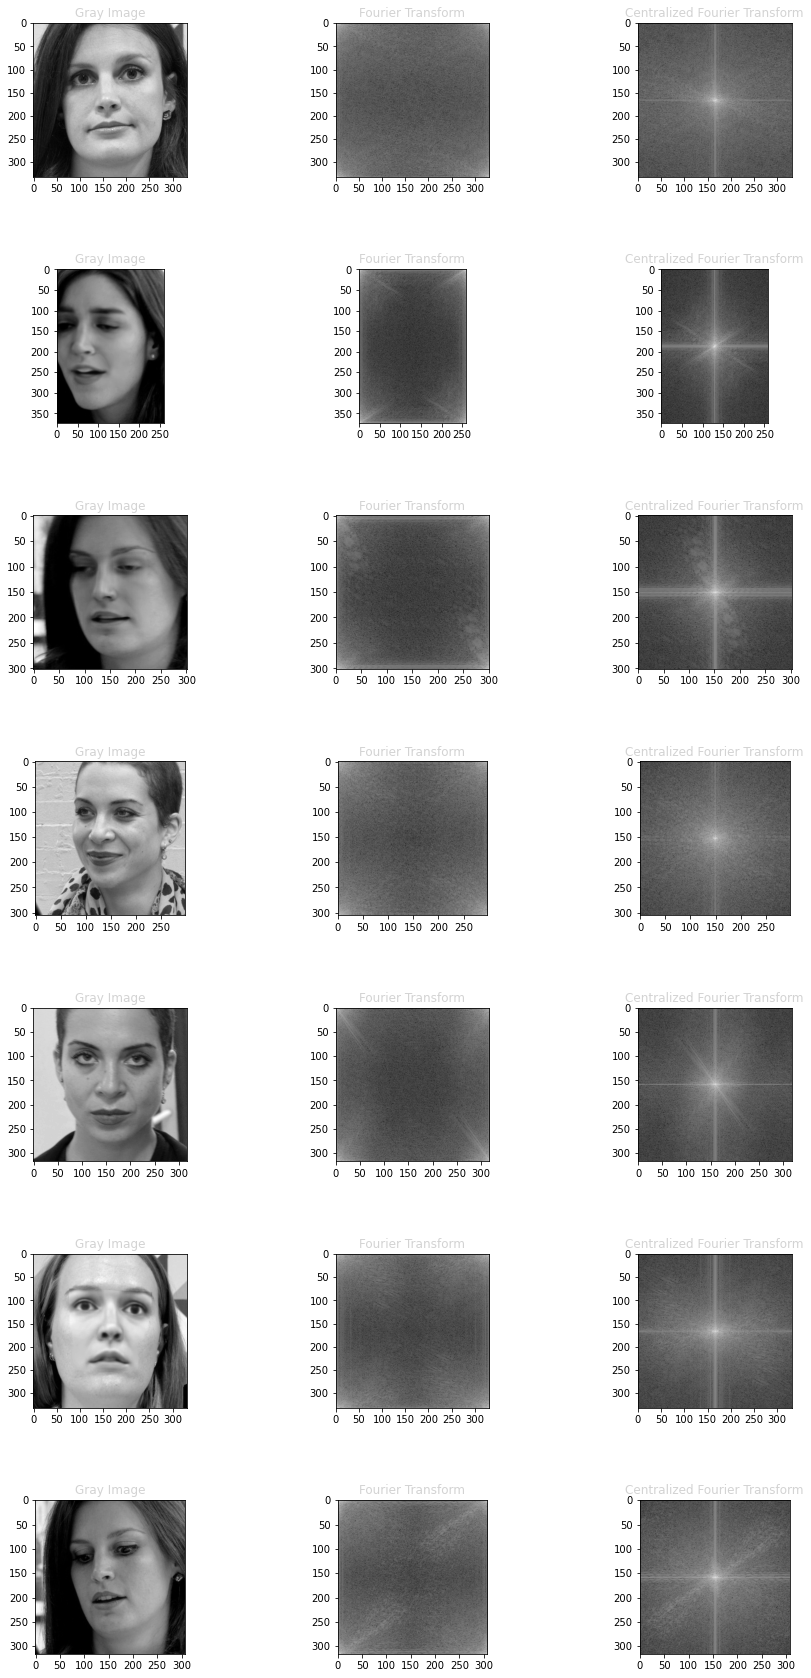

In [1]:
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Task 1 ##

def rgb2gray(img): # color image를 gray image로 convert하는 function
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def dft2D(img): # gray image를 Fourier transform하는 function
    height, width = img.shape
    x_indices = np.arange(height)[:, None]
    y_indices = np.arange(width)[None, :]

    exp_rows = -2j * np.pi * (x_indices * x_indices.T) / height
    exp_cols = -2j* np.pi * (y_indices * y_indices.T) / width

    dft_rows = np.matmul(img, np.exp(exp_cols))
    dft_result = np.matmul(np.exp(exp_rows), dft_rows)

    return dft_result

def centralize(ft): # Fourier transform의 result을 centralize하는 function
    return np.fft.fftshift(ft)



# 이미지 파일 path 목록 가져오기
image_paths = glob.glob("data/*.jpg")
image_paths.sort(key=lambda x: int(x.split("/")[-1].split(".")[0])) # 파일 이름에 적힌 번호를 기준으로 정렬
print(image_paths)
images = []

#Load the images
for img_path in image_paths:
    img = cv2.imread(img_path)

    # Append the image to the list
    images.append(img)

#Convert to grayscale
gray_images = []
for img in images:
    gray_images.append(rgb2gray(img))

#Perform 2D Fourier transform
ft_results = []
for gray_img in gray_images:
    ft_results.append(dft2D(gray_img))

#Centralize the Fourier transform result
centralized_ft_results = []
for ft0 in ft_results:
    centralized_ft_results.append(centralize(ft0))

#Visualization
fig, axs = plt.subplots(len(image_paths), 3, figsize=(15, 30)) # 7 rows and 3 columns의 figure 생성

# Process each image
for i in range(len(image_paths)):
    # Display the gray image
    axs[i, 0].imshow(gray_images[i], cmap='gray')
    axs[i, 0].set_title('Gray Image', color = 'lightgray')
    axs[i, 0].set_xticks(np.arange(0, gray_images[i].shape[1], 50))
    axs[i, 0].set_yticks(np.arange(0, gray_images[i].shape[0], 50))

    # Display the Fourier Transform result
    axs[i, 1].imshow(np.log1p(np.abs(ft_results[i])), cmap='gray') # Fourier Transform 결과의 크기에 1을 더해서 log를 취해줌.
    axs[i, 1].set_title('Fourier Transform', color = 'lightgray')
    axs[i, 1].set_xticks(np.arange(0, ft_results[i].shape[1], 50))
    axs[i, 1].set_yticks(np.arange(0, ft_results[i].shape[0], 50))

    # Display the Centralized Fourier Transform result
    axs[i, 2].imshow(np.log1p(np.abs(centralized_ft_results[i])), cmap='gray') # Centralized Fourier Transform 결과의 크기에 1을 더해서 log를 취해줌.
    axs[i, 2].set_title('Centralized Fourier Transform', color = 'lightgray')
    axs[i, 2].set_xticks(np.arange(0, centralized_ft_results[i].shape[1], 50))
    axs[i, 2].set_yticks(np.arange(0, centralized_ft_results[i].shape[0], 50))

# Ensure subplots do not overlap
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()



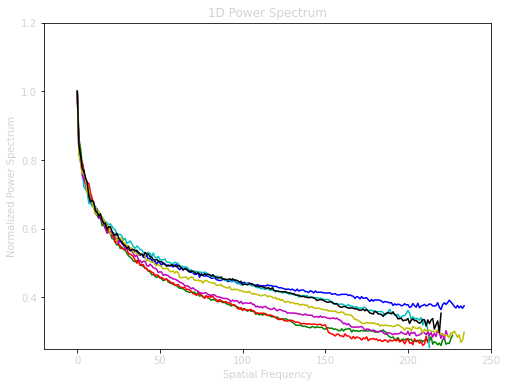

In [2]:
##Task 2##

#Azimuthal average function
def azimuthal_average(centralized_ft):
    # a. Calculate the center:
    h, w = centralized_ft.shape
    center = (h / 2, w / 2)

    # b. Compute the distance from the center to the pixels:
    y, x  = np.indices((h, w)) # y와 x array는 이미지의 각 pixel 위치에 대한 좌표를 나타냄.
    distances = np.sqrt((x - center[1])**2 + (y - center[0])**2) # center로부터 각 pixel 좌표까지의 distance 구하기
    reshaped_distances = np.reshape(distances, -1) # distance array(h x w의 배열)을 flatten하기

    # c. Take integer(>0) distances as the radius:
    distance_sorted_index = np.argsort(reshaped_distances) # 1D distance array의 원소를 오름차순으로 정렬했을 때의 index 구하기.
    distance_int = np.round(reshaped_distances[distance_sorted_index]).astype(int) # 정렬된 distance 값을 반올림하여 가장 가까운 정수로 만들어줌.

    # d. Make cumulative summation of frequency power values from integer type of distance 0 to integer type of max distance:
    freq_power_values = np.log(abs(centralized_ft)) # centralized_ft로부터 frequency power 계산
    reshaped_freq_power_values = np.reshape(freq_power_values, -1) # frequency power values array를 flatten하기
    freq_sorted = reshaped_freq_power_values[distance_sorted_index] # frequency power values array를 center로부터의 distance 순서대로 sort하기
    cum_sum_freq = np.cumsum(freq_sorted) # frequency power values을 cumulative summation하기

    # e. Average the frequency power values:
    unique_distance, unique_indices = np.unique(distance_int, return_index=True) # distance array의 중복을 제거한 값과 각 고유 거리값이 처음 등장하는 위치의 인덱스를 반환
    cum_sum_same_int_rad = cum_sum_freq[unique_indices[1:]-1] # 각 고유한 거리에 해당하는 frequency power value의 누적값을 계산
    summation_b2w_2radius = cum_sum_same_int_rad[1:] - cum_sum_same_int_rad[:-1] # 인접한 두 거리 사이의 cumulative sum을 계산 
    summation_b2w_2radius = np.hstack((cum_sum_same_int_rad[0], summation_b2w_2radius)) # distance 0(center pixel)에 있는 cum_sum_freq 값을 병합해줌
    num_pixels= unique_indices[1:] - unique_indices[:-1] # 인접한 두 거리 사이의 픽셀 수 계산
    averaged_spectrum = summation_b2w_2radius / num_pixels # 각 거리에 대한 평균 spectrum을 계산
    normalized_spectrum = averaged_spectrum / averaged_spectrum.max() # 평균 스펙트럼을 정규화함.

    return normalized_spectrum, unique_distance[:-1]

# f. Make 1D power spectrum
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # 각 이미지의 1d spectrum에 대한 color list 정의[b: 파랑(blue), g: 초록(green), r: 빨강(red), c: 청록(cyan), m: 자홍(magenta), y: 노랑(yellow), k: 검정(black)]

# 각 이미지의 azimuthal average 결과와 distances를 list에 저장
spectra = []
distances = []
for i in range(len(image_paths)):
    spectrum, distance = azimuthal_average(centralized_ft_results[i])
    spectra.append(spectrum)
    distances.append(distance)

# figure 생성
plt.figure(figsize=(8, 6))

# Plot the results for each image
for i in range(len(image_paths)):
    plt.plot(distances[i], spectra[i], color=colors[i])

plt.xlim(-20, 250)
plt.xticks(color = 'lightgray')
plt.ylim(0.25, 1.2)
plt.yticks(color = 'lightgray')
plt.xlabel('Spatial Frequency',color = 'lightgray')
plt.ylabel('Normalized Power Spectrum', color = 'lightgray')
plt.title('1D Power Spectrum', color = 'lightgray')
plt.show()



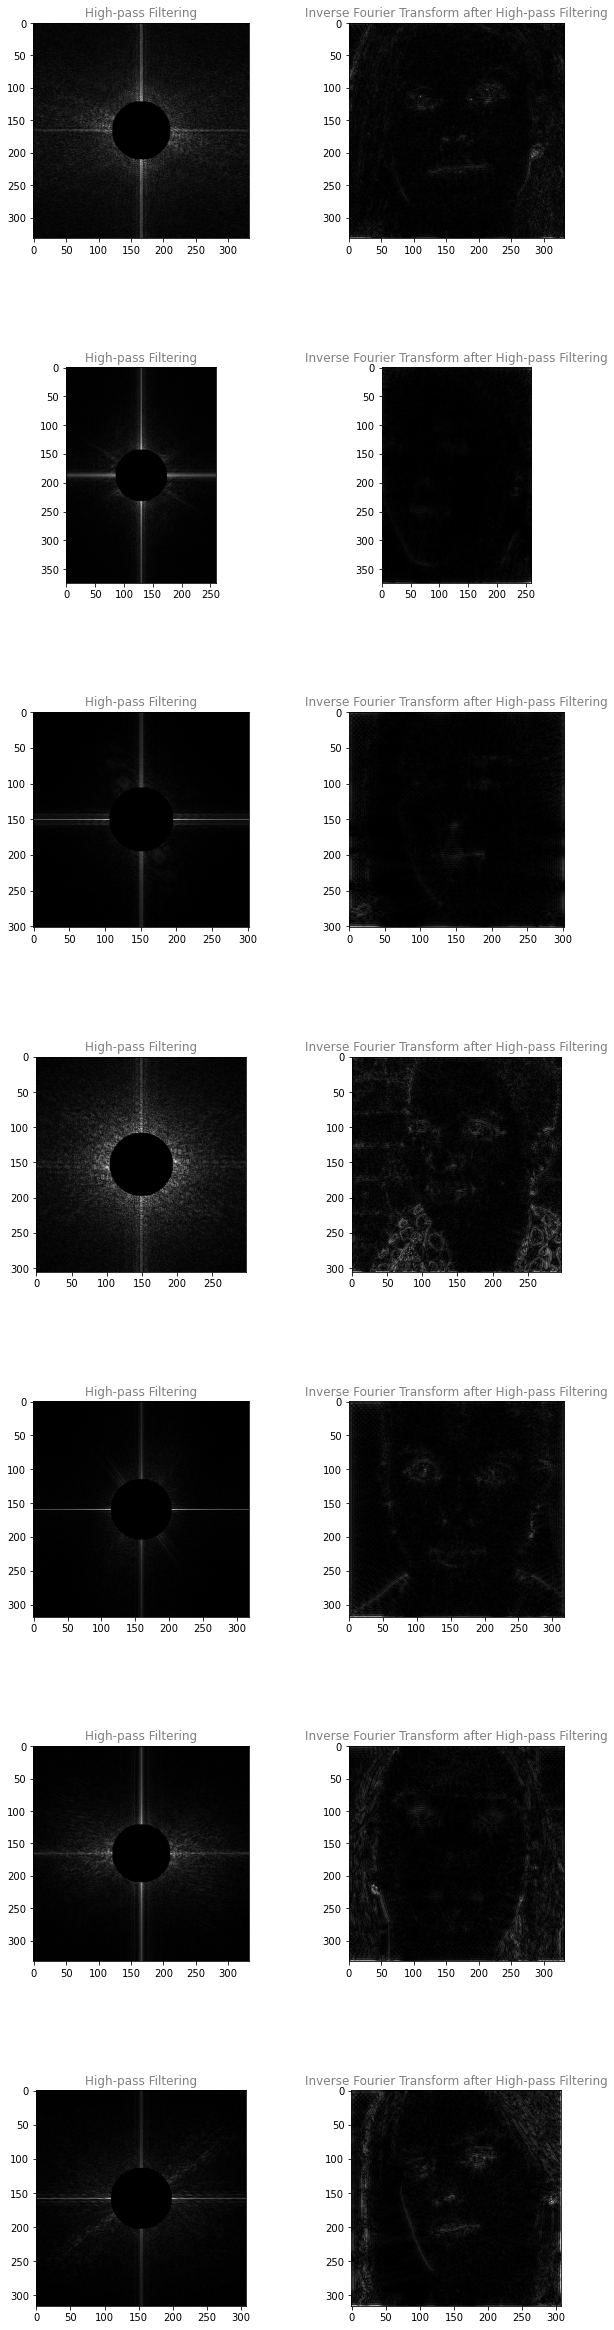

In [3]:
# Task 3

# 1. Create a High-Pass Filter
def create_circular_mask(img, radius):
    h, w = img.shape[:2] # color channels은 무시하고 height and weight만 가져옴.
    center = (w/2, h/2)
    
    Y, X = np.ogrid[:h, :w] # 이미지의 모든 픽셀 위치에 대한 그리드 생성
    dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    return mask

# 2. 2D Inverse Fourier Transform function

def idft2D(img):
    height, width = img.shape
    u_indices = np.arange(height)[:, None]
    v_indices = np.arange(width)[None, :]

    exp_rows = 2j * np.pi * (u_indices * u_indices.T) / height
    exp_cols = 2j * np.pi * (v_indices * v_indices.T) / width

    idft_rows = np.matmul(img, np.exp(exp_cols))
    idft_result = np.matmul(np.exp(exp_rows), idft_rows)

    return idft_result / (height * width)

# Implementation
# Create a figure with n rows and 1 column (one for each image)
fig, axs = plt.subplots(len(image_paths), 2, figsize=(10, 6*len(image_paths)))

# Process each image
for i in range(len(image_paths)):
    # 1. High Pass Filtering
    high_pass_mask = create_circular_mask(centralized_ft_results[i], radius = 45) 
    high_pass_img = centralized_ft_results[i] * high_pass_mask

    # 2. Perform Inverse Fourier Transform
    idft_img = idft2D(high_pass_img)

    # Calculate magnitude and normalize to 8-bit scale(0-255)
    idft_img_magnitude = np.abs(idft_img)
    normalized_img = 255 * idft_img_magnitude / np.max(idft_img_magnitude) # 0-255로 normalize
    normalized_img = normalized_img.astype(np.uint8) # 8-bit unsigned int로 convert

    # Display the result
    axs[i, 0].imshow(np.abs(high_pass_img), cmap='gray')
    axs[i, 0].set_title('High-pass Filtering', color = 'gray')
    axs[i, 0].set_xticks(np.arange(0, centralized_ft_results[i].shape[1], 50))
    axs[i, 0].set_yticks(np.arange(0, centralized_ft_results[i].shape[0], 50))
    axs[i, 1].imshow(normalized_img, cmap='gray')
    axs[i, 1].set_title('Inverse Fourier Transform after High-pass Filtering', color = 'gray')
    axs[i, 1].set_xticks(np.arange(0, centralized_ft_results[i].shape[1], 50))
    axs[i, 1].set_yticks(np.arange(0, centralized_ft_results[i].shape[0], 50))

# Ensure subplots do not overlap
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

아래는 Task 3의 결과를 정량적으로 분석할 때 사용한 코드입니다.

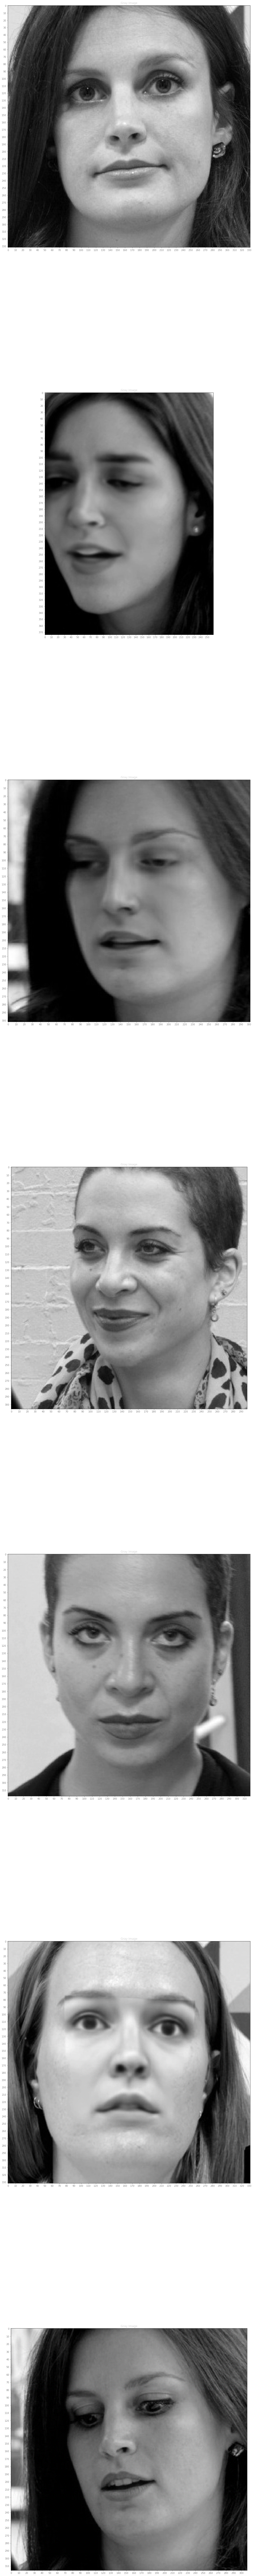

In [4]:
# gray image의 fig size를 키우고 눈금 단위를 작게 하여 눈 부위의 픽셀 범위를 찾아내기 위해 작성한 코드.
#Visualization
fig, axs = plt.subplots(len(image_paths), figsize=(100, 200)) #rows의 수를 image의 개수로 설정

# Process each image
for i in range(len(image_paths)):
    # Display the gray image
    axs[i].imshow(gray_images[i], cmap='gray')
    axs[i].set_title('Gray Image', color = 'lightgray')
    axs[i].set_xticks(np.arange(0, gray_images[i].shape[1], 10))
    axs[i].tick_params(axis='x', colors='gray')
    axs[i].set_yticks(np.arange(0, gray_images[i].shape[0], 10))
    axs[i].tick_params(axis='y', colors='gray')

# Ensure subplots do not overlap
plt.subplots_adjust(hspace=0.6)
plt.show()

눈 위의 픽셀 범위는 (height, width)의 순서로 나열하면 다음과 같이 나왔습니다.
000.jpg: (90, 135), (80, 240)/
001.jpg: (120, 160), (0, 155)/
002.jpg: (80, 120), (75, 215)/
003.jpg: (90, 120), (80, 220)/
004.jpg: (80, 125), (80, 250)/
005.jpg: (90, 135), (80, 250)/
006.jpg: (80, 135), (75, 220)

In [5]:
# 눈 부위의 pixel 범위에 해당하는 high freq 성분값의 크기를 모두 더해주는 함수.
# 각 이미지에 대해 함수를 적용해주고 눈 부위의 high freq components의 크기의 합을 출력해줌.

# Define the eye pixel ranges for each image
eye_pixel_ranges = np.array([
    [(90, 135), (80, 240)],
    [(120, 160), (0, 155)],
    [(80, 120), (75, 215)],
    [(90, 120), (80, 220)],
    [(80, 125), (80, 250)],
    [(90, 135), (80, 250)],
    [(80, 135), (75, 220)]
])

# Function to calculate the sum of high frequency components in the eye region
def sum_eye_freq_components(image_paths, eye_pixel_ranges):
    sum_eye_freqs = []

    # Process each image
    for i in range(len(image_paths)):
        # 1. High Pass Filtering
        high_pass_mask = create_circular_mask(centralized_ft_results[i], radius = 45)
        high_pass_img = centralized_ft_results[i] * high_pass_mask

        # 2. Perform Inverse Fourier Transform
        idft_img = idft2D(high_pass_img)

        # Calculate magnitude
        idft_img_magnitude = np.abs(idft_img)

        # Crop the eye region from the idft image magnitude
        eye_region = idft_img_magnitude[eye_pixel_ranges[i][0][0]:eye_pixel_ranges[i][0][1], 
                                    eye_pixel_ranges[i][1][0]:eye_pixel_ranges[i][1][1]]

        # Calculate and append the sum of high frequency components in the eye region
        sum_eye_freqs.append(np.round(np.sum(eye_region)))

    return sum_eye_freqs

# Call the function
sum_eye_freq_components = sum_eye_freq_components(image_paths, eye_pixel_ranges)
print(sum_eye_freq_components)


[27457.0, 7478.0, 6114.0, 17128.0, 21934.0, 14279.0, 23225.0]


아래는 real과 fake image를 구분할 수 있는 저만의 threshold를 만들어서 fake image를 detection할 수 있는 함수를 구현한 코드입니다.

In [6]:
# fake image detection 구현

def fake_image_detection(sum_eye_freq_components):
    # Calculate the maximum high frequency sum
    max_sum = np.max(sum_eye_freq_components)
    
    # Create a dictionary to hold the classifications
    classifications = {}
    
    # Classify each image
    for i, high_freq_sum in enumerate(sum_eye_freq_components):
        # If the eye freq components sum divided by the max sum is greater or equal to 0.5, classify as 'real'
        if high_freq_sum / max_sum >= 0.6:
            classifications[i] = 'real'
        else: # If the high frequency sum divided by the max sum is less than 0.5, classify as 'fake'
            classifications[i] = 'fake'
    
    return classifications

fake_image_detection = fake_image_detection(sum_eye_freq_components)
print(fake_image_detection)



{0: 'real', 1: 'fake', 2: 'fake', 3: 'real', 4: 'real', 5: 'fake', 6: 'real'}


In [ ]:
아래는 레포트의 Discussion 단계에서 결과물을 더 잘 뽑아내기 위해 조건을 바꿔보는 과정을 작성한 코드입니다.

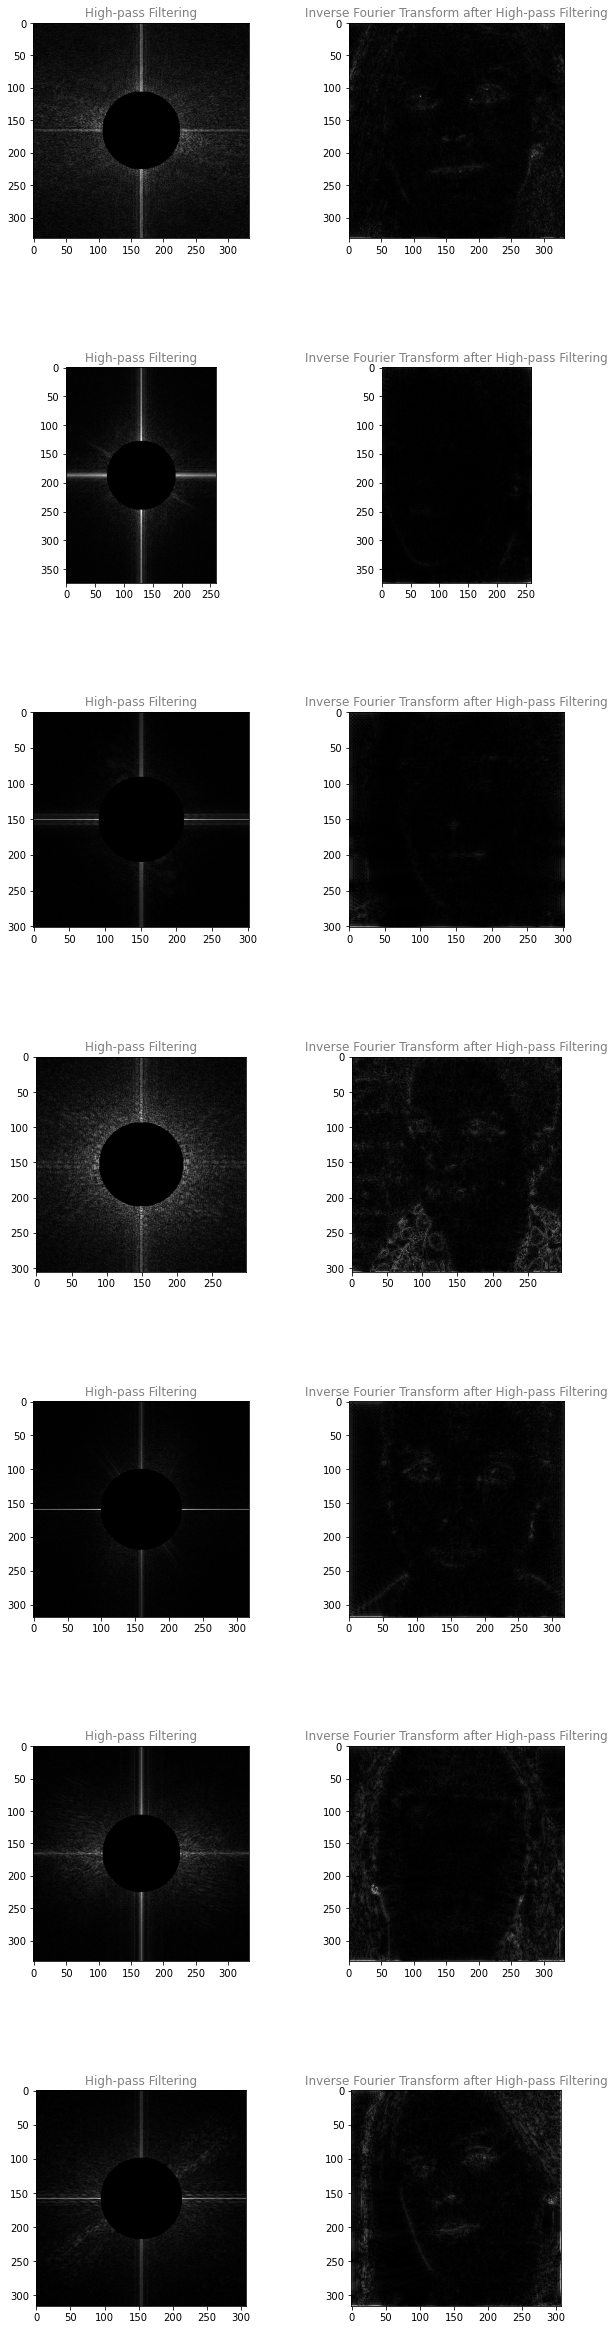

In [57]:
# Circular mask의 radius를 조절해보자.

# Task 3

# 1. Create a High-Pass Filter
def create_circular_mask(img, radius):
    h, w = img.shape[:2] # color channels은 무시하고 height and weight만 가져옴.
    center = (w/2, h/2)
    
    Y, X = np.ogrid[:h, :w] # 이미지의 모든 픽셀 위치에 대한 그리드 생성
    dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    return mask

# 2. 2D Inverse Fourier Transform function

def idft2D(img):
    height, width = img.shape
    u_indices = np.arange(height)[:, None]
    v_indices = np.arange(width)[None, :]

    exp_rows = 2j * np.pi * (u_indices * u_indices.T) / height
    exp_cols = 2j * np.pi * (v_indices * v_indices.T) / width

    idft_rows = np.matmul(img, np.exp(exp_cols))
    idft_result = np.matmul(np.exp(exp_rows), idft_rows)

    return idft_result / (height * width)

# Implementation
# Create a figure with n rows and 1 column (one for each image)
fig, axs = plt.subplots(len(image_paths), 2, figsize=(10, 6*len(image_paths)))

# Process each image
for i in range(len(image_paths)):
    # 1. High Pass Filtering
    high_pass_mask = create_circular_mask(centralized_ft_results[i], radius = 60) 
    high_pass_img = centralized_ft_results[i] * high_pass_mask

    # 2. Perform Inverse Fourier Transform
    idft_img = idft2D(high_pass_img)

    # Calculate magnitude and normalize to 8-bit scale(0-255)
    idft_img_magnitude = np.abs(idft_img)
    normalized_img = 255 * idft_img_magnitude / np.max(idft_img_magnitude) # 0-255로 normalize
    normalized_img = normalized_img.astype(np.uint8) # 8-bit unsigned int로 convert

    # Display the result
    axs[i, 0].imshow(np.abs(high_pass_img), cmap='gray')
    axs[i, 0].set_title('High-pass Filtering', color = 'gray')
    axs[i, 0].set_xticks(np.arange(0, centralized_ft_results[i].shape[1], 50))
    axs[i, 0].set_yticks(np.arange(0, centralized_ft_results[i].shape[0], 50))
    axs[i, 1].imshow(normalized_img, cmap='gray')
    axs[i, 1].set_title('Inverse Fourier Transform after High-pass Filtering', color = 'gray')
    axs[i, 1].set_xticks(np.arange(0, centralized_ft_results[i].shape[1], 50))
    axs[i, 1].set_yticks(np.arange(0, centralized_ft_results[i].shape[0], 50))

# Ensure subplots do not overlap
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()



아래는 인터넷 상에 있는 Facial detection model을 이용해서 눈과 입 부위를 detect하여 그 부분의 frequency magnitude를 구하는 과정을 담은 코드입니다.

In [8]:
import urllib.request as urlreq
import cv2
import os

# save facial landmark detection model's url and name
LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
LBFmodel = "lbfmodel.yaml"

# save face detection algorithm's url and name
haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
haarcascade = "haarcascade_frontalface_alt2.xml"

# check if file is in working directory
if (haarcascade in os.listdir(os.curdir)):
    print("Face detection model exists")
else:
    # download file from url and save locally as haarcascade_frontalface_alt2.xml
    urlreq.urlretrieve(haarcascade_url, haarcascade)
    print("Face detection model downloaded")

# check if file is in working directory
if (LBFmodel in os.listdir(os.curdir)):
    print("Facial landmark detection model exists")
else:
    # download file from url and save locally as lbfmodel.yaml
    urlreq.urlretrieve(LBFmodel_url, LBFmodel)
    print("Facial landmark detection model downloaded")

# create an instance of the Face Detection Cascade Classifier
detector = cv2.CascadeClassifier(haarcascade)

# create an instance of the Facial landmark Detector with the model
landmark_detector  = cv2.face.createFacemarkLBF()
landmark_detector.loadModel(LBFmodel)

# initialize lists to save landmarks
landmarks_list = []

# load, process images and extract landmarks
for img_path in image_paths:
    # load image in grayscale mode
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # perform face detection
    faces = detector.detectMultiScale(img_gray)
    
    # perform landmark detection and append to landmarks_list
    _, landmarks = landmark_detector.fit(img_gray, faces)
    landmarks_list.append(landmarks)

print("Landmarks extracted for all images.")


# 먼저, 얼굴의 랜드마크에 대한 정보를 바탕으로 눈과 입의 영역을 픽셀 단위로 파악하는 함수를 작성해야 한다.
# 주어진 랜드마크들은 눈과 입의 위치를 나타내는 좌표들이며, 이들을 사용해 각 부위의 최소와 최대 x, y 값을 찾아 영역을 결정할 수 있습니다.

def get_eyes_and_mouth_regions(landmarks):
    # landmarks for eyes are 36-47, and for mouth are 48-67 according to the model's documentation
    eyes_landmarks = landmarks[0][36:48]
    mouth_landmarks = landmarks[0][48:68]

    # find min and max for x, y coordinates for each part
    eyes_region = [min(eyes_landmarks, key=lambda p: p[0])[0], max(eyes_landmarks, key=lambda p: p[0])[0], 
                   min(eyes_landmarks, key=lambda p: p[1])[1], max(eyes_landmarks, key=lambda p: p[1])[1]]
    mouth_region = [min(mouth_landmarks, key=lambda p: p[0])[0], max(mouth_landmarks, key=lambda p: p[0])[0], 
                    min(mouth_landmarks, key=lambda p: p[1])[1], max(mouth_landmarks, key=lambda p: p[1])[1]]

    return eyes_region, mouth_region

# 이제 고주파 성분 크기의 합을 계산하는 함수를 작성한다.

def sum_freq_components(image_paths, region_pixel_ranges, radius=45):
    sum_freqs = []

    # Process each image
    for i in range(len(image_paths)):
        # 1. High Pass Filtering
        high_pass_mask = create_circular_mask(centralized_ft_results[i], radius=radius)
        high_pass_img = centralized_ft_results[i] * high_pass_mask

        # 2. Perform Inverse Fourier Transform
        idft_img = idft2D(high_pass_img)

        # Calculate magnitude
        idft_img_magnitude = np.abs(idft_img)

        # Crop the region from the idft image magnitude
        region = idft_img_magnitude[region_pixel_ranges[i][0]:region_pixel_ranges[i][1], 
                                    region_pixel_ranges[i][2]:region_pixel_ranges[i][3]]

        # Calculate and append the sum of high frequency components in the region
        sum_freqs.append(np.round(np.sum(region)))

    return sum_freqs


# Implementation
print(landmarks_list)
model_eyes_pixel_ranges, model_mouth_pixel_ranges = get_eyes_and_mouth_regions(landmarks_list)

sum_eye_freqs = sum_freq_components(image_paths, model_eyes_pixel_ranges)
sum_mouth_freqs = sum_freq_components(image_paths, model_mouth_pixel_ranges)


Face detection model exists
Facial landmark detection model exists
loading data from : lbfmodel.yaml
Landmarks extracted for all images.
[(array([[[ 61.401993, 153.16531 ],
        [ 60.67077 , 178.12369 ],
        [ 65.130165, 205.11678 ],
        [ 70.43847 , 230.91739 ],
        [ 76.68078 , 255.71487 ],
        [ 88.489784, 277.5167  ],
        [110.35921 , 292.06076 ],
        [138.05438 , 297.88992 ],
        [169.00647 , 296.85867 ],
        [201.3274  , 292.34985 ],
        [231.98064 , 279.9951  ],
        [257.0966  , 263.92108 ],
        [272.34305 , 240.98451 ],
        [279.61993 , 212.89064 ],
        [283.39426 , 185.00368 ],
        [287.34045 , 154.40599 ],
        [286.75217 , 125.275505],
        [ 65.62674 , 106.12143 ],
        [ 77.209785,  92.00608 ],
        [ 95.38569 ,  86.19419 ],
        [114.13591 ,  86.24228 ],
        [131.7651  ,  93.84898 ],
        [174.40895 ,  85.07597 ],
        [193.4627  ,  71.18098 ],
        [216.7027  ,  65.47591 ],
        [23

ValueError: min() arg is an empty sequence